# The Bayesian Bootstrap Is Not a Free Lunch

Some recent work has suggested that we can solve computationally difficult, multi-modal Bayesian posterior calculations with optimization and bootstrap sampling.  There are many variations such methods; for shorthand I will simply refer to them collectively as Bayesian bootstrap (BB) methods.  It is true that BB can be practically quite informative, and, in certain problems, much more useful than any other out-of-the-box Bayesian methods which fail utterly to explore multiple modes.  Nevertheless, I will argue that BB methods do not, in general, produce an accurate approximation of a Bayesian posterior.  

I will argue that when we are actually interested in a particular multi-modal parametric posterior but simply cannot sample from it, then BB methods will not, in general, approximate the desired posterior.  Of course, the BB is the right thing to do when we actually do have a proper Dirichlet process prior on a space of data distributions, and are interested in the output of a particular optimization problem as a posterior quantity.  But naively replacing a parametric Bayesian posterior quantity with a BB quantity risks (a) misinterpreting what is meant by an optimum and (b) misinterpreting what is meant by uncertainty.  I stress that I do not mean to argue that the BB is not useful.  A flawed answer can better than no answer at all.  But a flawed answer is even more useful when its potential shortcomings are well understood, and my aim is to clearly and intuitively illustrate these potential shortcomings.  

### Model 1

I will begin with a toy model which is simple and contrived.  Its simplicity is such that we can clearly see what the right Bayesian answer should be, and how the BB fails to replicate it.  I will argue in future, less simple examples that its contrivance is not so severe, and that the failure of the BB in this simple model illustrate its potential failures in more complex cases. 

Suppose we observe a vector of scalar, real-valued data $x=(x_1,...,x_N)$, drawn from the following model:

$$
\begin{align}
p(\tau) &= \mathrm{Gamma}(\tau | 1, 1)\\
p(x | \tau) &= \prod_{n=1}^N \mathcal{N}(x_n | \tau, 1).
\end{align}
$$

The unkown mean parameter $\tau$ is positive, and all other aspects of the data generating process are known.  As stated, this is a simple problem.  Now, let us suppose that we are actually interested in a quantity $\theta \in \mathbb{R}$, given by

$$
\begin{align}
z &\in \{-1, 1\}\\
p(z=1) &= 0.8\\
\theta &= z \sqrt{\tau}.
\end{align}
$$

Obviously, $|\theta| = \tau$, and $p(\theta  > 0 | x) = 0.8$ because the data $x$ is independent of $z$, the sign of $\theta$.

Effectively, the sign of $\theta$ is identified only by the prior, and the posterior $p(\theta \vert x)$ has both a positive mode and a negative mode, which it occupies with respective probabilities $0.8$ and $0.2$.  We can sample from the posterior of $p(\theta | x)$ by sampling from $p(\tau | x)$, drawing $z$ from its prior, and setting $\theta = z \tau$.

Can the BB reproduce a reasonable approximation of the posterior $p(\theta | x)$ in this trivial case?  Below, I will show that it cannot.  The reason is twofold and general.  Recall that the probability probability of a lying near a particular mode is determined by the posterior mass under the mode.  For example, in the present case, $p(\theta > 0 | x) = \int_{0}^{\infty} p(\theta | x) d\theta = 0.8$.  However, in general,

- The frequency with which an optimum finds a mode is not, in general, determined by the relative mass of a mode and
- The variability of an optimum induced by the bootstrap is not, in general, determined by the relative mass of a mode. 

In [1]:
library(tidyverse)
library(rstan)
library(gridExtra)
library(numDeriv)
library(repr)

# Change plot size to 4 x 3
options(repr.plot.width=7, repr.plot.height=4)

options(mc.cores=4)
rstan_options(auto_write=TRUE)

setwd("/home/rgiordan/Documents/git_repos/variational_bayes/bayesian_bootstrap")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
EvalLogPost <- function(theta, fit, z_prob) {
  upars <- unconstrain_pars(fit, list(tau=theta ^ 2))
  lp <- log_prob(fit, upars) + ifelse(theta > 0, log(z_prob), log(1 - z_prob))
}

GetThetaGridLp <- function(fit, z_prob, theta_max=NA) {
  draws <- extract(fit)
  if (!is.finite(theta_max)) {
      theta_max <- 1.3 * max(abs(draws$theta))      
  }
  theta_grid <- seq(-1 * theta_max, theta_max, length.out=1000)
  lp <- sapply(theta_grid, EvalLogPost, fit, z_prob)
  return(data.frame(theta=theta_grid, lp=lp))
}

DrawAndFit <- function(N, z_prob, tau_prior_shape=1, tau_prior_rate=1, x_sd=1) {
  tau_true <- rgamma(1, shape=tau_prior_shape, rate=tau_prior_rate)
  x <- rnorm(N, mean=tau_true, sd=x_sd)
  # Also save tau_true even though Stan doesn't use it.
  bb_data <- list(x=x, N=N, prob=z_prob, x_sd=x_sd,
                  tau_prior_shape=tau_prior_shape, tau_prior_rate=tau_prior_rate,
                  tau_true=tau_true)

  # The Stan model will exhibit some divergent transitions near 0, but that's
  # not a real problem here.
  fit <- stan(file='multimodal_v1.stan', data=bb_data)
  return(list(fit=fit, bb_data=bb_data))  
}

Let's draw a dataset and look at the posterior of $\theta$.

In [3]:
z_prob <- 0.8
initial_fit <- DrawAndFit(N=50, z_prob=z_prob)
fit <- initial_fit$fit

hash mismatch so recompiling; make sure Stan code ends with a blank line


P(\theta > 0) \approx  0.7975 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


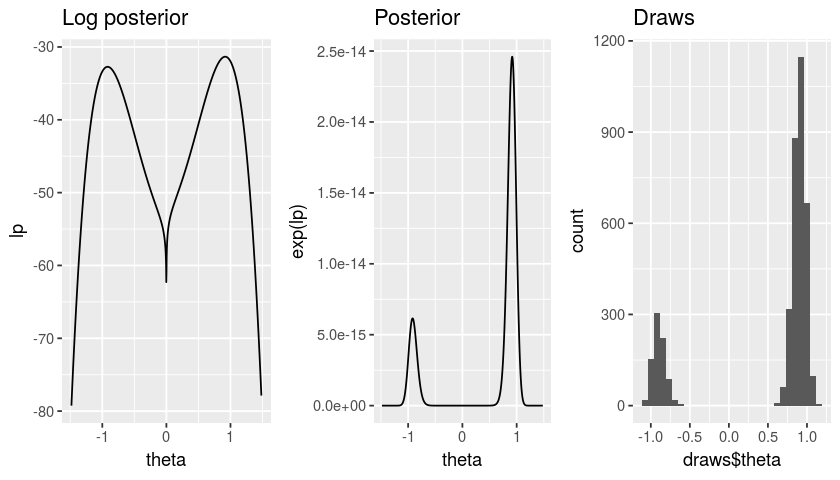

In [4]:
draws <- extract(fit)
cat("P(\\theta > 0) \\approx ", mean(draws$theta > 0), "\n")

theta_lp <- GetThetaGridLp(fit, z_prob)
grid.arrange(
  ggplot(theta_lp) +
    geom_line(aes(x=theta, y=lp)) +
    ggtitle("Log posterior")
,
  ggplot(theta_lp) +
    geom_line(aes(x=theta, y=exp(lp))) +
    ggtitle("Posterior")
,  
    ggplot() + 
      geom_histogram(aes(x=draws$theta)) +
      ggtitle("Draws")
, ncol=3
)

Now, let's see whether the Bayesian bootstrap will reproduce $p(\theta > 0 | x) = 0.8$.

First of all, note that reasonable optimizers (e.g. well-conditined gradient ascent) will find the positive mode if the initial value is positive, and the negative mode if the initial value is negative.  So, irrespective of the noise induced by the bootstrap, the BB estimate of $P(\theta > 0)$ will be precisely the probability that the initial value for optimization is positive.  With uniform random restarts, this probability will be $0.5$, not $0.8$.

A resonable question is whether drawing bootstrap samples of $x$ can overcome this obvious shortcoming.  Let's take a look.

In [5]:
DrawBootstrapSample <- function(x) {
    return(x[sample.int(length(x), replace=TRUE)])
}

GetBootstrapFit <- function(initial_fit) {
  x_boot <- DrawBootstrapSample(initial_fit$bb_data$x)
  bb_data_boot <- initial_fit$bb_data
  bb_data_boot$x <- x_boot

  # We only need the fit object, not the draws, so set samples to be very low and
  # suppress output and warnings.
  options(warn=-1)
  invisible(capture.output(
      fit_boot <- stan(file='multimodal_v1.stan',
                       data=bb_data_boot, iter=1, chains=1)))
  options(warn=0)
  return(list(x_boot=x_boot, fit_boot=fit_boot))
}


In [6]:
theta_max <- 2 * max(abs(draws$theta))
mean_abs_theta <- mean(abs(draws$theta))

boot_lp_df <- data.frame()
for (b in 1:10) {
    print(b)
    boot_fit <- GetBootstrapFit(initial_fit)
    theta_lp <- GetThetaGridLp(boot_fit$fit, z_prob, theta_max)
    boot_lp_df <- bind_rows(boot_lp_df, theta_lp %>% mutate(b=as.character(b)))
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


As we can see, the bootstrap variability is never such that the lower mode is larger than the higher mode.  Consequently, if our optimization method finds the global optimum rather than a local optimum, it will estimate $p(\theta > 0 | x) = 1$.

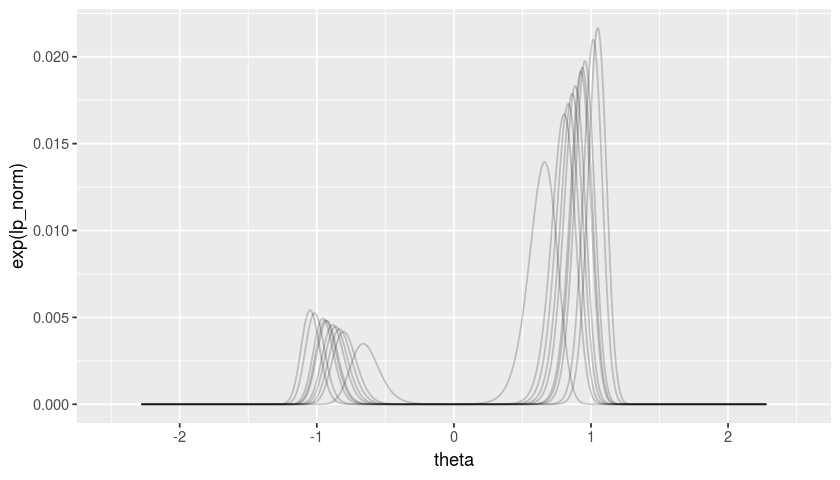

In [7]:
boot_lp_df <-
    boot_lp_df %>%
    group_by(b) %>%
    mutate(lp_norm=lp - log(sum(exp(lp)))) # Were this to be a density you would need the delta x

ggplot(boot_lp_df) +
    geom_line(aes(x=theta, y=exp(lp_norm), group=b), alpha=0.2) +
    xlim(-2.5, 2.5)

Let's check this formally by actually optimizing a number of bootstrap samples.

In [8]:
GetMAP <- function(fit, init_val=NA, width=NA, pos=TRUE) {
  # init_val and width are in the log space.
  x_sign <- (sign(pos) * 2 - 1)
  Objective <- function(log_x) {
    x <- x_sign * exp(log_x)
    # The log probability doesn't matter because we're only finding the optimum in
    # one of the two modes.
    return(-1 * EvalLogPost(x, fit, 0.5))
  }
  if (!is.finite(init_val)) {
    init_val  <- log(mean(sqrt(extract(fit, "tau")$tau)))
  }
  if (!is.finite(width)) {
    width <- 4 * sd(log(sqrt(extract(fit, "tau")$tau)))
  }
  opt <- optim(init_val, Objective, method="Brent",
               upper=init_val + width, lower=init_val - width)
  opt$par_theta <- x_sign * exp(opt$par)
  return(opt)
}


GetBootstrapResult <- function(fit_boot, z_prob, init_val=NA, width=NA) {
  boot_opt <- GetMAP(fit_boot, pos=TRUE, init_val=init_val, width=width)
  lp_neg <- EvalLogPost(-1 * boot_opt$par_theta, fit_boot, z_prob)
  lp_pos <- EvalLogPost(boot_opt$par_theta, fit_boot, z_prob)
  lp_hess_neg <- hessian(
      function(x) EvalLogPost(x, fit_boot, z_prob),
      -1 * boot_opt$par_theta)[1, 1]
  lp_hess_pos <- hessian(
      function(x) EvalLogPost(x, fit_boot, z_prob),
      boot_opt$par_theta)[1, 1]

  return(data.frame(
    theta_opt=ifelse(lp_pos > lp_neg, 1, -1) * boot_opt$par_theta,
    lp_pos=lp_pos,
    lp_neg=lp_neg,
    lp_hess_neg=lp_hess_neg,
    lp_hess_pos=lp_hess_pos
  ))
}

In [9]:
init_val  <- log(mean(sqrt(draws$tau)))
width <- 4 * sd(log(sqrt(draws$tau)))

B <- 50
boot_df <- data.frame()
boot_time <- Sys.time()

for (b in 1:B) {
  fit_boot <- GetBootstrapFit(initial_fit)$fit_boot
  boot_df <- bind_rows(
      boot_df,
      GetBootstrapResult(fit_boot, z_prob, init_val=init_val, width=width))
}
boot_time <- Sys.time() - boot_time


In [10]:
cat("BB estimate of P(\\thetasign(boot_df$theta_opt): ", mean(boot_df$theta_opt > 0), "\n")

BB estimate of P(\thetasign(boot_df$theta_opt):  1 


### Summary

In summary, there are two flavors of the BB: one which finds a local optimum, and one which finds a global optimum.  The former estimates $p(\theta > 0 | x) \approx 0.5$, and the latter estimates $p(\theta > 0 | x) \approx 1.0$.  Neither is a good estimate of the true $p(\theta > 0 | x) = 0.8$.

What has gone wrong?  The value chosen by the BB depends on two things:
- The domain of attraction and the distribution of the starting point
- The variability of the height of the optima under data resampling.

Neither of these quantites necessarily have anything to do with the real posterior probability, which is the mass under the mode.

### Model

For reference, here is a dump of the Stan model.

In [16]:
cat(scan("multimodal_v1.stan", what="character", sep="\n"), sep="\n")

data {
  int<lower=0> N;
  real x[N];
  real<lower=0> x_sd;
  real<lower=0, upper=1> prob;
  real<lower=0> tau_prior_shape;
  real<lower=0> tau_prior_rate;
}
parameters {
  real<lower=0> tau;
}
model {
  tau ~ gamma(tau_prior_shape, tau_prior_rate);
  x ~ normal(tau, x_sd);
}
generated quantities {
  real theta;
  int z;
  z = 2 * bernoulli_rng(prob) - 1;
  theta = z * sqrt(tau);
}
